In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 kB 8.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 34.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 23.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras.backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
tf.compat.v1.disable_eager_execution()
import shap

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#counter
from time import sleep
from tqdm import tqdm
from tqdm import trange

In [3]:
#Grad-CAM Model
def grad_cam(model, X, c, layer_name,size, img=None):
 

  y_c = model.output[0, c]#Takes the probability value of the predicted class
  conv = model.get_layer(layer_name)#Gets the last convolutional layer whose outputs are feature maps
  grads = K.gradients(y_c, conv.output)[0]  #Derivative of y_c with respect to feature maps
  #Is a matrix whose elements are the gradients of y_c and A_ij
  # K.function allows you to run the computational graph that we have created
  # In this case we have an input and 2 OTPUTS: (i) the features maps (ii) the gradient at the last convolutional level
  gradient_function = K.function([model.input], [conv.output, grads]) #The output of the last conv layer are features maps
  feature_maps, grads_val = gradient_function([X])
  feature_maps, grads_val = feature_maps[0, ...], grads_val[0, ...]

  # a_{k} ^c
  #Let's calculate the global average of the gradient
  weights = np.mean(grads_val, axis=(0, 1)) #Average over the entire feature maps, one weight for each feature map, is a vector
  
  # sum_{k} ( a_{k} ^c * A^{k})
  products = np.empty((feature_maps.shape), dtype='float32')
  for i in range(feature_maps.shape[2]): #Feature_maps.shape[2] counts the third dimension, i.e. how many feat maps there are
    products[:,:,i] = weights[i] * feature_maps[:,:,i]#Are a group of matrices
  linear_combination = np.sum(products, axis=2)#Sum matrix per matrix, along the third dimension

  # ReLU ( sum_{k} ( a_{k} ^c * A^{k}) )
  grad_cam = np.maximum(linear_combination, 0)#Takes the value of the instance only if greater than zero

  # Process grad_CAM
  grad_cam = cv2.resize(grad_cam, (size, size), cv2.INTER_LINEAR)#Bring the size of the mask to those of the input
  grad_cam = grad_cam / grad_cam.max()#Normalize the values of the mask
  grad_cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)#Apply colours to the mask
  if img is not None:
    grad_cam = (np.float32(grad_cam) + img) / 2 #Sum the mask and input and divide by two not to count twice the pixels
  else:
    grad_cam = np.float32(grad_cam) 
  return np.uint8(grad_cam)#uint8 are integers of 8 bit from 0 to 255


In [4]:
#Load VGG16 model
vgg_model = VGG16(include_top= True, weights='imagenet', pooling= 'max', input_shape=(224,224,3), classes=1000)

553476096/553467096 [==============================] - 5s 0us/step


2022-11-22 16:06:33.008777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 16:06:33.579715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


In [5]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
img_name = "dog.jpg"

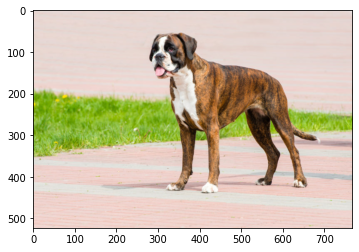

In [24]:
#Load image file
img = cv2.imread(img_name, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [25]:
#transform image to array
#img = keras.preprocessing.image.load_img(img)
img = keras.preprocessing.image.img_to_array(img)
img = cv2.resize(img, (224,224)).astype('float32')
img.shape

(224, 224, 3)

In [26]:
#add dimension to array
x = np.expand_dims(img, axis=0)

y = vgg_model.predict(x)

#prediction
print(np.argmax(y))
results = decode_predictions(y, top=20)[0]
for result in results:
        print(result)
cl = np.argmax(y)
#print also second top prediction
y = np.delete(y,cl)
cl2 = np.argmax(y)
print(cl2)

246
('n02109047', 'Great_Dane', 0.9829549)
('n02091134', 'whippet', 0.011122872)
('n02091831', 'Saluki', 0.004968406)
('n02092002', 'Scottish_deerhound', 0.0003071794)
('n02091032', 'Italian_greyhound', 0.00027177652)
('n02092339', 'Weimaraner', 0.00024721664)
('n02091244', 'Ibizan_hound', 4.7346643e-05)
('n02113978', 'Mexican_hairless', 2.4224955e-05)
('n02100236', 'German_short-haired_pointer', 2.2255099e-05)
('n02090721', 'Irish_wolfhound', 1.5294874e-05)
('n03803284', 'muzzle', 5.592229e-06)
('n02088632', 'bluetick', 2.6926348e-06)
('n02107142', 'Doberman', 1.6992927e-06)
('n02108089', 'boxer', 1.6333775e-06)
('n02437312', 'Arabian_camel', 1.5901172e-06)
('n02116738', 'African_hunting_dog', 1.0871377e-06)
('n02089973', 'English_foxhound', 1.0295521e-06)
('n02087394', 'Rhodesian_ridgeback', 7.4543357e-07)
('n02110341', 'dalmatian', 5.0939855e-07)
('n02090379', 'redbone', 3.2881212e-07)
172


In [27]:
# To sum Heatmap and X
#img = keras.preprocessing.image.load_img(img, grayscale=True)
#img = keras.preprocessing.image.img_to_array(img,grayscale=True)
img = cv2.imread(img_name,0)
img = cv2.resize(img, (224,224)).astype('float32')
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

In [28]:
#Grad-CAM calculation
h = grad_cam(vgg_model, x, cl, "block5_conv3", 224, img)  

In [29]:
#Heatmap
h.shape

(224, 224, 3)

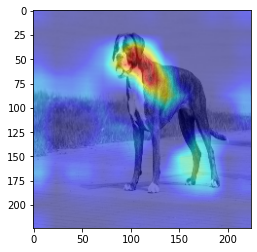

In [30]:
#plot result
plt.imshow(cv2.cvtColor(h, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
#second top prediction
h2 = grad_cam(vgg_model, x, cl2, "block5_conv3", 224, img)

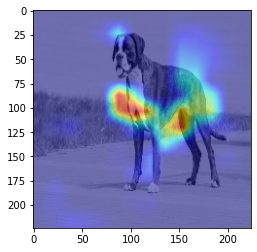

In [32]:
#plot result
plt.imshow(cv2.cvtColor(h2, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
#shap
#deep explainer
X,y = shap.datasets.imagenet50()

#training
ex = shap.DeepExplainer(vgg_model, X[0:5])

In [34]:
#Shap values
shap_values_t, indexes = ex.shap_values(x,ranked_outputs=2,check_additivity=False)

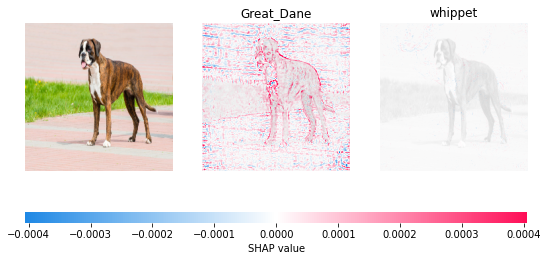

In [35]:
#Plot result
shap.image_plot(shap_values_t, (x).astype(np.uint8), labels= [results[0][1],results[1][1]])

In [ ]:
#gradient explainer
def map2layer(x, layer):
    feed_dict = dict(zip([vgg_model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(vgg_model.layers[layer].input, feed_dict)

In [37]:
#Shap Value
e = shap.GradientExplainer((vgg_model.layers[7].input, vgg_model.layers[-1].output), map2layer(X[0:5], 7))
shap_values_2,indexes = e.shap_values(map2layer(x, 7), ranked_outputs=2)

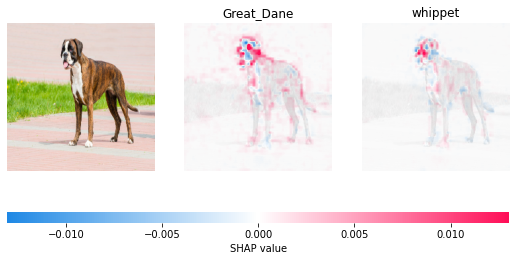

In [38]:
#Plot result
shap.image_plot(shap_values_2, (x).astype(np.uint8), labels= [results[0][1],results[1][1]])